In [1]:
!pip install imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
# sklearn packages (for pre-processing, model-building, evaluators, cross-validators, etc.)
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder

# Imblearn packages (for over_sampling and imblearn pipelines)
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline  ## Using packages from imblearn.pipeline for making pipelines

## xgboost packages
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

!pip install tqdm
from tqdm import tqdm

from random import sample

## Sampling

In [2]:
# undersampling the non frauds to have 5% frauds
df_cct = pd.read_parquet("/home/onyxia/work/df_sampling1.parquet")
df_nofraud = df_cct[df_cct["Is Fraud?"] == 0]
df_nofraud_sampled = df_nofraud.sample(int(0.95*(10658/0.05)), random_state = 0)

In [3]:
df_cct

,User,Card,Month,Day,Hours,year_diff,Amount,Use Chip,Card Brand,Card Type,...,nb_monthly_declines_card,bad_pin,insufficient_balance,hr_nbt/last_30d_av_hr_nbt,day_nbt/last_30d_av_day_nbt,last_3d_amt/nbt,label_global,Is Fraud?,pos_amount,abs_amount
3668,0,2,0.833333,0.266667,1.000000,-0.125,-0.263269,Swipe Transaction,Visa,Debit,...,-0.5,0,0,2.585752,0.777221,-0.948859,0,0,0,50.00
3669,0,2,0.833333,0.266667,1.000000,-0.125,-0.263269,Swipe Transaction,Visa,Debit,...,-0.5,0,0,2.419999,0.739251,-0.907894,0,0,1,50.00
3670,0,3,0.833333,0.333333,0.000000,-1.125,0.290346,Swipe Transaction,Visa,Credit,...,0.0,0,0,0.016575,-0.556789,0.519504,0,0,1,98.66
3671,0,0,0.833333,0.333333,0.000000,-0.625,0.743273,Swipe Transaction,Visa,Debit,...,0.5,0,0,-0.014861,-0.098799,1.097525,0,0,1,138.47
3672,0,2,0.833333,0.333333,0.142857,-0.125,-0.384777,Online Transaction,Visa,Debit,...,-0.5,0,0,-0.323219,0.107374,-0.917636,0,0,1,39.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24385063,1999,1,-1.000000,0.200000,-0.333333,0.500,-0.286161,Online Transaction,Visa,Credit,...,1.0,0,0,-0.005671,0.250511,-0.044696,0,0,1,45.16
24385064,1999,1,-1.000000,0.200000,0.000000,0.500,0.637998,Chip Transaction,Visa,Credit,...,1.0,0,0,1.143920,0.249014,0.029287,-1,0,1,68.80
24385065,1999,1,-1.000000,0.200000,0.000000,0.500,0.393667,Chip Transaction,Visa,Credit,...,1.0,0,0,1.131969,0.246232,0.052006,0,0,1,62.55
24385066,1999,1,-1.000000,0.200000,0.750000,0.500,0.121970,Online Transaction,Visa,Credit,...,1.0,0,0,1.120142,0.243457,0.035329,-1,0,1,55.60


In [4]:
# recreating the dataframe
df_fraud = df_cct[df_cct["Is Fraud?"] == 1]
df_cct = pd.concat([df_nofraud_sampled, df_fraud], axis = 0).sort_index()

In [5]:
df_cct.reset_index(drop=True,inplace=True)

In [32]:
df_test_final = pd.read_parquet("/home/onyxia/work/df_test_final.parquet")

### One Hot Encoder

In [6]:
# For "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [7]:
# For "Card Brand":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Brand"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [8]:
# For "Card Type":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Type"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [9]:
# For "label global":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["label_global"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [10]:
df_cct.rename(columns={0:"0", -1: "-1", 1:"1", 2:"2", 3: "3", 4:"4", 5:"5", 6:"6"}, inplace=True)


In [11]:
df_cct.columns


Index(['User', 'Card', 'Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?', 'pos_amount', 'abs_amount', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction', 'Amex', 'Discover',
       'Mastercard', 'Visa', 'Credit', 'Debit', 'Debit (Prepaid)', '-1', '0',
       '1', '2', '3', '4', '5', '6'],
      dtype='object')

In [15]:
df_test_final.columns

Index(['User', 'Card', 'Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?', 'pos_amount', 'abs_amount', 'Amex', 'Discover',
       'Mastercard', 'Visa', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction', 'Credit', 'Debit', 'Debit (Prepaid)', '-1', '0',
       '1', '2', '3', '4', '5', '6'],
      dtype='object')

## Splitting

In [35]:
# selecting features

features = ['Month', 'Day', 'Hours', 'year_diff', 'Amount', 'pos_amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)',"Is Fraud?",
        "-1","0","1","2","3","4","5","6"]

df_selec = df_cct[features] # 21 features + clusters

# defining X and y

X_train = df_selec[['Month', 'Day', 'Hours', 'year_diff', 'Amount', 'pos_amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)',"-1","0","1","2","3","4","5","6"]]
       
y_train = df_selec["Is Fraud?"]

In [36]:
X_test_ = df_test_final[['Month', 'Day', 'Hours', 'year_diff', 'Amount', 'pos_amount',
              'Credit Limit', 'delta_t_s',
              'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
              'nb_monthly_declines_card', 'bad_pin',
              'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
              'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
              'Swipe Transaction','Debit (Prepaid)',"-1","0","1","2","3","4","5","6"]]

y_test_ = df_test_final["Is Fraud?"]

In [37]:
## Checking class distribution in stratified train-test split
from collections import Counter

print("In y dataset:", Counter(y))
print("\nIn y_train set:", Counter(y_train))
print("\nIn y_test set:", Counter(y_test_))

In y dataset: Counter({0: 202502, 1: 10439})

In y_train set: Counter({0: 202502, 1: 10439})

In y_test set: Counter({0: 38000, 1: 2087})


## Model Building

In [61]:
#building our own score
def our_score(df_cct, clf, X, y):

    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel() # retrieving tn, fp, fn, tp
    
    fp_rows = [] 

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 0:
            fp_rows.append(y.index[i]) 

    fn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 1:
            fn_rows.append(y.index[i])

    tp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 1:
            tp_rows.append(y.index[i])

    tn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 0:
            tn_rows.append(y.index[i])

    df_fp = df_cct.loc[fp_rows] 
    fp_new = df_fp.loc[df_fp["abs_amount"]>=15].index # defining fp rows which amount above 15$

    df_tp = df_cct.loc[tp_rows]
    tp_new = df_tp.loc[df_tp["abs_amount"]>=15].index

    df_fn = df_cct.loc[fn_rows]
    fn_new = df_fn.loc[df_fn["abs_amount"]>=15].index

    our_score = -15*(len(fp_new) + len(tp_new)) + df_cct.loc[tp_new]["abs_amount"].sum() - df_cct.loc[fn_rows]["abs_amount"].sum() - df_cct.loc[tp_rows]["abs_amount"].sum()

    our_score_norm = (our_score + df_cct.loc[fn_rows]["abs_amount"].sum() + df_cct.loc[tp_rows]["abs_amount"].sum())/(df_cct.loc[tp_new]["abs_amount"].sum()+df_cct.loc[fn_new]["abs_amount"].sum() - 15*(len(tp_new)+len(fn_new)))

    return our_score_norm

In [62]:
#calculate retrieved or lost money
def retrieved_money(df_cct, clf, X, y):

    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    fp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 0:
            fp_rows.append(y.index[i])

    fn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 1:
            fn_rows.append(y.index[i])

    tp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 1:
            tp_rows.append(y.index[i])

    tn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 0:
            tn_rows.append(y.index[i])

    df_fp = df_cct.loc[fp_rows]
    fp_new = df_fp.loc[df_fp["abs_amount"]>=15].index

    df_tp = df_cct.loc[tp_rows]
    tp_new = df_tp.loc[df_tp["abs_amount"]>=15].index

    df_fn = df_cct.loc[fn_rows]
    fn_new = df_fn.loc[df_fn["abs_amount"]>=15].index

    initial_loss = - df_cct.loc[fn_rows]["abs_amount"].sum() - df_cct.loc[tp_rows]["abs_amount"].sum()

    retrieved_money = -15*(len(fp_new) + len(tp_new)) + df_cct.loc[tp_new]["abs_amount"].sum() 

    max_retrieved_money = df_cct.loc[tp_new]["abs_amount"].sum()+df_cct.loc[fn_new]["abs_amount"].sum() - 15*(len(tp_new)+len(fn_new))

    return initial_loss, retrieved_money, max_retrieved_money

In [40]:
# plot confusion matrix
def plot_confusion_matrix(cm):
    """
    This function prints and plots the confusion matrix.
    """
    classes=['Non-Fraudulent','Fraudulent']
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize= 10)
    plt.xlabel('Predicted label', fontsize=10)

In [41]:
## Define a function to plot ROC_AUC curve
def plot_roc_auc_curve(fpr, tpr, roc_auc):
    print(f"ROC for test dataset {round(roc_auc*100,3)}%")  
    plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.plot(fpr,tpr,'b',label="Test ROC_AUC="+str(round(roc_auc,3)))
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.legend(loc='lower right')
    plt.show()

In [42]:
# 10 fold CV
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=10, shuffle=False)
kf.split(X_train, y_train)
for train_index, test_index in kf.split(X_train, y_train):
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape , str("\n"))
    print("TRAIN:", train_index, "\n\nTEST:", test_index , str("\n"))

TRAIN: (191646,) TEST: (21295,) 

TRAIN: [ 21196  21197  21198 ... 212938 212939 212940] 

TEST: [    0     1     2 ... 21307 21308 21309] 

TRAIN: (191647,) TEST: (21294,) 

TRAIN: [     0      1      2 ... 212938 212939 212940] 

TEST: [21196 21197 21198 ... 45464 45465 45466] 

TRAIN: (191647,) TEST: (21294,) 

TRAIN: [     0      1      2 ... 212938 212939 212940] 

TEST: [42454 42455 42456 ... 65456 65457 65458] 

TRAIN: (191647,) TEST: (21294,) 

TRAIN: [     0      1      2 ... 212938 212939 212940] 

TEST: [63756 63757 63758 ... 89607 89608 89609] 

TRAIN: (191647,) TEST: (21294,) 

TRAIN: [     0      1      2 ... 212938 212939 212940] 

TEST: [ 84917  84918  84919 ... 109891 109892 109893] 

TRAIN: (191647,) TEST: (21294,) 

TRAIN: [     0      1      2 ... 212938 212939 212940] 

TEST: [106214 106215 106216 ... 130522 130523 130570] 

TRAIN: (191647,) TEST: (21294,) 

TRAIN: [     0      1      2 ... 212938 212939 212940] 

TEST: [127675 127676 127677 ... 149767 149860 14986

## Decision Tree

In [47]:
# GridSearch
from sklearn.model_selection import GridSearchCV
param = {
    "class_weight" : [{1:i, 0:1} for i in [10, 20, 50]],
    "min_samples_leaf" : [1, 5, 10, 25, 50, 100, 200],
    "max_depth" : [1, 5, 10, 15, 20, 25, 30]
 }

model = DecisionTreeClassifier(random_state = 0)
CV_model = GridSearchCV(estimator=model, cv = kf, n_jobs = -1, param_grid = param, scoring = our_score,verbose=10)
CV_model.fit(X_train, y_train)


Fitting 10 folds for each of 147 candidates, totalling 1470 fits
[CV 1/10; 1/147] START class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 3/10; 1/147] START class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 4/10; 1/147] START class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 5/10; 1/147] START class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 2/10; 1/147] START class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 9/10; 1/147] START class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 10/10; 1/147] START class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 8/10; 1/147] START class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 6/10; 1/147] START class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 5/10; 2/147] START class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=5
[CV 7/10; 1/147] START class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 3/10; 2/147] STAR

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 20},
                                          {0: 1, 1: 50}],
                         'max_depth': [1, 5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [1, 5, 10, 25, 50, 100, 200]},
             scoring=<function our_score at 0x7fb26ad0be20>, verbose=10)

In [48]:
print(CV_model.best_params_)

{'class_weight': {1: 10, 0: 1}, 'max_depth': 5, 'min_samples_leaf': 200}


In [51]:
print(CV_model.best_score_)

0.6700016058141438


In [309]:
print(CV_model.best_estimator_)

DecisionTreeClassifier(class_weight={0: 1, 1: 10}, max_depth=5,
                       min_samples_leaf=100, random_state=0)


### Results on test set

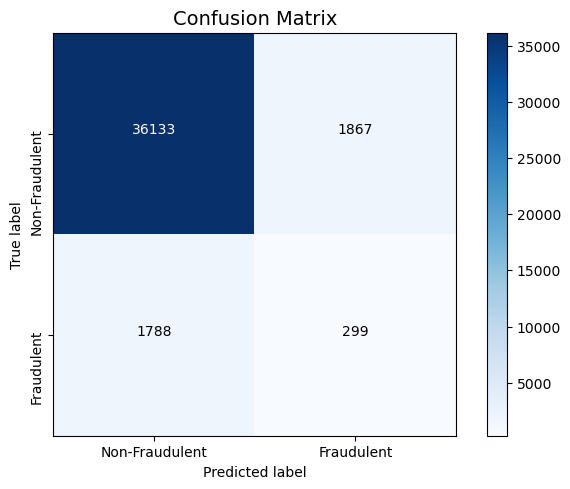

In [72]:
dt_opt = DecisionTreeClassifier(random_state = 0, class_weight={1:10, 0:1}, max_depth= 5, min_samples_leaf=200)
dt_opt.fit(X_train,y_train)
y_pred_dt = dt_opt.predict(X_test_)
cm_dt_opt = confusion_matrix(y_test_, y_pred_dt)
plot_confusion_matrix(cm_dt_opt)

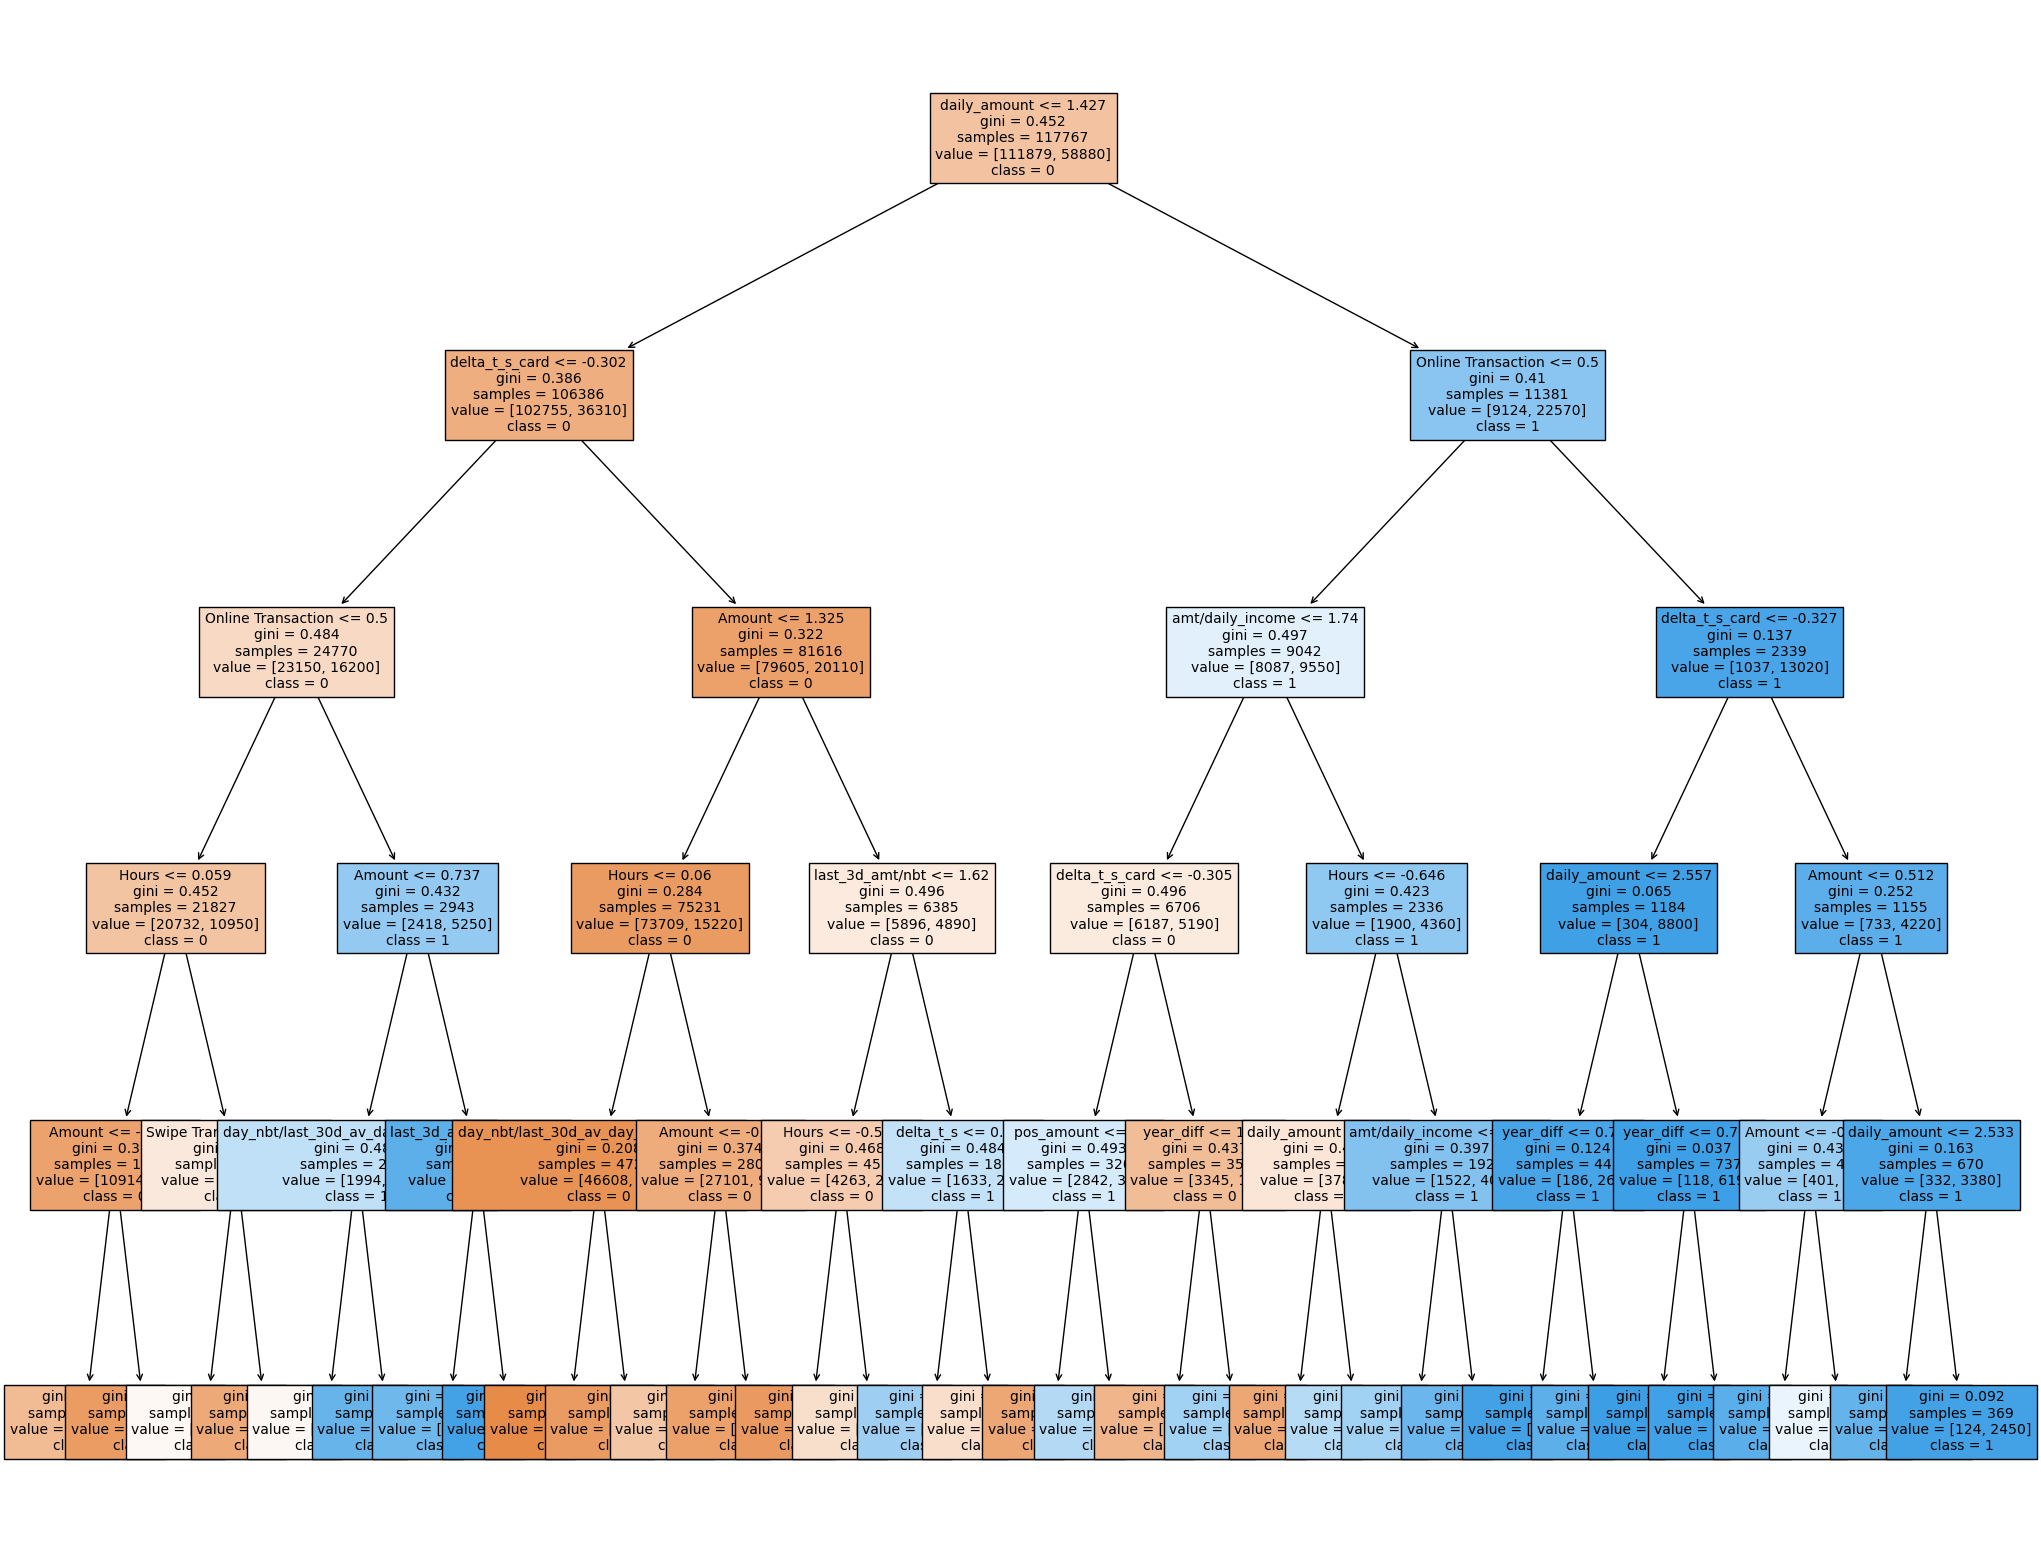

In [36]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt_opt, 
                   feature_names=X.columns,  
                   class_names=["0","1"],
                   filled=True, fontsize=10)

ROC for test dataset 54.707%


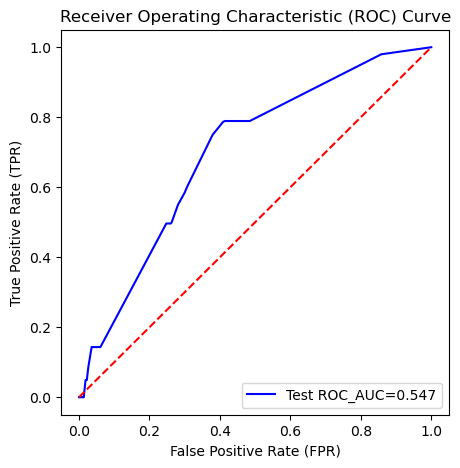

In [75]:
y_pred_proba = dt_opt.predict_proba(X_test_)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_,  y_pred_proba)
roc_auc = roc_auc_score(y_test_, y_pred_dt, average=None)
plot_roc_auc_curve(fpr, tpr, roc_auc)

In [76]:
print("Precision score is ", precision_score(y_test_, y_pred_dt))
print("Recall score is ", recall_score(y_test_, y_pred_dt))
print("f1 score is", f1_score(y_test_, y_pred_dt))

Precision score is  0.13804247460757155
Recall score is  0.14326784858648778
f1 score is 0.14060663061368445


In [77]:
print("Our score is", our_score(df_test_final, dt_opt, X_test_, y_test_))

Our score is 0.2769413258679182


In [78]:
print("The initial loss was equal to", retrieved_money(df_test_final, dt_opt, X_test_, y_test_)[0], "dollars, \nwe retrieved", retrieved_money(df_test_final, dt_opt, X_test_, y_test_)[1], "dollars and the maximum amount that was retrievable is", retrieved_money(df_test_final, dt_opt, X_test_, y_test_)[2], "dollars.")

The initial loss was equal to -185096.86 dollars, 
we retrieved 44306.17 dollars and the maximum amount that was retrievable is 159983.96000000002 dollars.


## Random Forest

In [58]:
# GridSearch
param = {
    "class_weight" : [{1:i, 0:1} for i in [10, 15, 20]],
    "min_samples_leaf" : [1, 5, 10, 25, 50, 100, 200],
    "max_depth" : [1, 5, 10, 15, 20, 25, 30],
    "n_estimators" : [50, 100, 200, 300]
 }

model2 = RandomForestClassifier(random_state = 0, n_jobs = -1)
CV_model2 = GridSearchCV(estimator=model2, cv = kf, n_jobs = -1, param_grid = param, scoring = our_score,verbose=10)
CV_model2.fit(X_train, y_train)

Fitting 10 folds for each of 588 candidates, totalling 5880 fits
[CV 2/10; 1/588] START class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=50
[CV 4/10; 1/588] START class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=50
[CV 9/10; 1/588] START class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=50
[CV 1/10; 1/588] START class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=50
[CV 5/10; 1/588] START class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=50
[CV 1/10; 2/588] START class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=100
[CV 6/10; 1/588] START class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=50
[CV 3/10; 1/588] START class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=50
[CV 7/10; 1/588] START class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=50
[CV 10/10; 1/588] START class_weig

/opt/mamba/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 10/10; 17/588] END class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=50, n_estimators=50;, score=0.431 total time=  12.0s
[CV 2/10; 19/588] START class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=50, n_estimators=200
[CV 5/10; 15/588] END class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=25, n_estimators=200;, score=0.456 total time=  26.2s
[CV 6/10; 15/588] END class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=25, n_estimators=200;, score=0.439 total time=  26.8s
[CV 3/10; 15/588] END class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=25, n_estimators=200;, score=0.551 total time=  29.9s
[CV 3/10; 17/588] END class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=50, n_estimators=50;, score=0.529 total time=  15.9s
[CV 2/10; 15/588] END class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=25, n_estimators=200;, score=0.441 total time=  31.4s
[CV 1/10; 17/588] END class_weight={1: 10, 0: 1}, max_depth=1, min_samples_leaf=50, n_estimato

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 15},
                                          {0: 1, 1: 20}],
                         'max_depth': [1, 5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [1, 5, 10, 25, 50, 100, 200],
                         'n_estimators': [50, 100, 200, 300]},
             scoring=<function our_score at 0x7fb26a036830>, verbose=10)

In [59]:
print(CV_model2.best_params_)

{'class_weight': {1: 15, 0: 1}, 'max_depth': 30, 'min_samples_leaf': 25, 'n_estimators': 300}


In [60]:
print(CV_model2.best_score_)

0.7239380084743623


### Results on test set

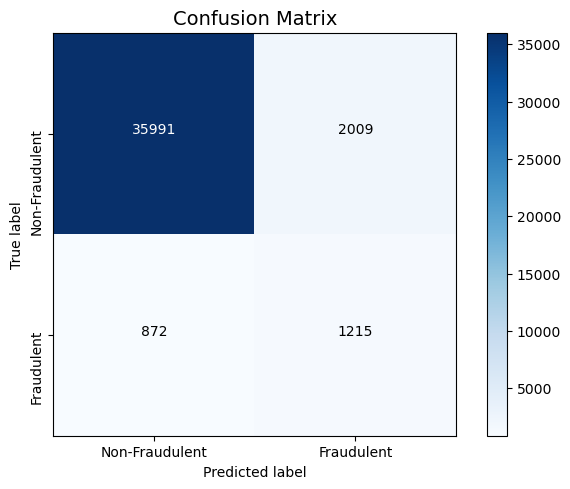

In [63]:
rf_opt = RandomForestClassifier(random_state = 0, class_weight= {1: 15, 0: 1}, max_depth= 30, min_samples_leaf= 25, n_estimators= 300, n_jobs = -1)
rf_opt.fit(X_train,y_train)
y_pred_rf = rf_opt.predict(X_test_)
cm_rf_opt = confusion_matrix(y_test_, y_pred_rf)
plot_confusion_matrix(cm_rf_opt)

ROC for test dataset 76.465%


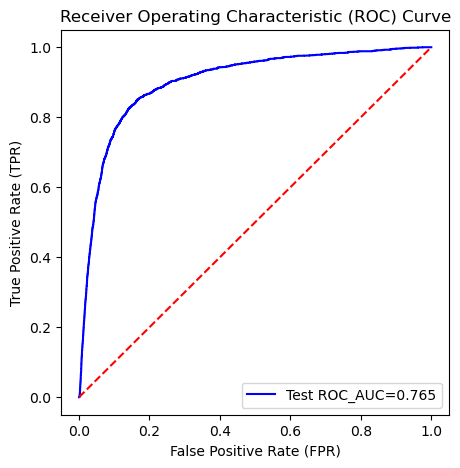

In [71]:
y_pred_proba_rf = rf_opt.predict_proba(X_test_)[::,1]
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test_,  y_pred_proba_rf)
roc_auc_rf = roc_auc_score(y_test_, y_pred_rf, average=None)
plot_roc_auc_curve(fpr_rf, tpr_rf, roc_auc_rf)

In [66]:
print("Our score is equal to", our_score(df_test_final, rf_opt, X_test_, y_test_))

Our score is equal to 0.6092833931601642


In [69]:
print("The initial loss was equal to", retrieved_money(df_test_final, rf_opt, X_test_, y_test_)[0], "dollars, \nwe retrieved", retrieved_money(df_test_final, rf_opt, X_test_, y_test_)[1], "dollars and the maximum amount that was retrievable is", retrieved_money(df_test_final, rf_opt, X_test_, y_test_)[2], "dollars.")

The initial loss was equal to -185096.86 dollars, 
we retrieved 97475.57 dollars and the maximum amount that was retrievable is 159983.96000000002 dollars.


In [70]:
print("Precision score is ", precision_score(y_test_, y_pred_rf))
print("Recall score is ", recall_score(y_test_, y_pred_rf))
print("f1 score is", f1_score(y_test_, y_pred_rf))

Precision score is  0.3768610421836228
Recall score is  0.5821753713464303
f1 score is 0.45754095273959705
